In [1]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

Welcome to JupyROOT 6.28/00


2023-04-17 07:36:17.116701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 07:36:19.044541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[]
Num GPUs Available:  0


2023-04-16 21:17:16.368459: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)

DMesonsTTree = process_ntuple(dir_path, files[0])
LambdaMesonsTTree = process_ntuple(dir_path, files[1])

branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId"]

print(files)

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root', 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']


In [4]:
branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId"]
DMesons_df = show(0, DMesonsTTree, branches, 0)
DMesons_df = remove_empty(DMesons_df)

DMesons_df["DMesons_pt"] = DMesons_df["DMesons_pt"].apply(divide_by_1000)
for col in DMesons_df.columns:
    DMesons_df[col] = DMesons_df[col].apply(list)
DMesons_df = apply_cuts(DMesons_df)

In [5]:
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,[10.047125],[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411]
1,"[18.9937421875, 18.9937421875]","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]"
2,"[10.118494140625, 10.118494140625]","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]"
3,"[12.579470703125, 12.579470703125]","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]"
4,[36.1288359375],[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122]
...,...,...,...,...,...,...
8235046,[17.96],[-0.6264557838439941],[1865.6043701171875],[5.87862491607666],[0.45278045535087585],[411]
8235047,"[62.91061328125, 62.91061328125]","[0.2775037884712219, 0.2775037884712219]","[1847.262451171875, 2131.1259765625]","[11.870012283325195, 11.870012283325195]","[-0.9544855356216431, -0.9355815052986145]","[411, 4122]"
8235048,"[14.8181767578125, 14.8181767578125]","[-2.1479332447052, -2.1479332447052]","[1836.0997314453125, 2165.72412109375]","[2.027026653289795, 2.027026653289795]","[-0.9712575674057007, -0.9517184495925903]","[411, 4122]"
8235049,[39.3814296875],[1.5503557920455933],[2210.86669921875],[0.17065481841564178],[-0.332907497882843],[4122]


In [23]:
# DMesons_df = generate_df(DMesonsTTree, branches, 100)
# DMesons_df = apply_cuts(DMesons_df)
# DMesons_df

In [24]:
# Lambda_df = generate_df(LambdaMesonsTTree, branches, 100)
# Lambda_df = apply_cuts(Lambda_df)
# Lambda_df

In [2]:
DMesons_df = load("DMesons_df")
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,[10.047125],[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411]
1,"[18.9937421875, 18.9937421875]","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]"
2,"[10.118494140625, 10.118494140625]","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]"
3,"[12.579470703125, 12.579470703125]","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]"
4,[36.1288359375],[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122]
...,...,...,...,...,...,...
7417090,[17.96],[-0.6264557838439941],[1865.6043701171875],[5.87862491607666],[0.45278045535087585],[411]
7417091,"[62.91061328125, 62.91061328125]","[0.2775037884712219, 0.2775037884712219]","[1847.262451171875, 2131.1259765625]","[11.870012283325195, 11.870012283325195]","[-0.9544855356216431, -0.9355815052986145]","[411, 4122]"
7417092,"[14.8181767578125, 14.8181767578125]","[-2.1479332447052, -2.1479332447052]","[1836.0997314453125, 2165.72412109375]","[2.027026653289795, 2.027026653289795]","[-0.9712575674057007, -0.9517184495925903]","[411, 4122]"
7417093,[39.3814296875],[1.5503557920455933],[2210.86669921875],[0.17065481841564178],[-0.332907497882843],[4122]


In [3]:
DMesons_df = remove_duplicates(DMesons_df)

Removed 0 duplicate particles


In [4]:
DMesons_df = DMesons_df.head(1000000)

In [6]:
#separates each particle of the event into it's own event in a new data frame (for training)
dfs = []
for index, row in DMesons_df.iterrows():
    
    pts = row['DMesons_pt']
    etas = row['DMesons_eta']
    ms = row['DMesons_m']
    lxys = row['DMesons_fitOutput__Lxy']
    costhetastars = row['DMesons_costhetastar']
    pdgids = row["DMesons_pdgId"]
        
    d = {DMesons_df.columns[0]: pts, DMesons_df.columns[1]: etas, DMesons_df.columns[2]: ms, DMesons_df.columns[3]: lxys, 
         DMesons_df.columns[4]: costhetastars, DMesons_df.columns[-1]: pdgids}
    df = pd.DataFrame(data=d)
    
    dfs.append(df)

df = pd.concat(dfs)
df = df.reset_index(drop = True)
df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,10.047125,0.081824,1862.417603,2.339530,0.254870,411
1,18.993742,-1.661963,1853.906250,1.918414,-0.367302,411
2,18.993742,-1.661963,2398.886963,1.918414,-0.065073,4122
3,10.118494,0.041659,1874.203125,2.890126,0.068331,411
4,10.118494,0.041659,2468.180664,2.890126,0.427697,4122
...,...,...,...,...,...,...
1660074,12.158312,0.132812,1869.685547,0.588506,0.557646,411
1660075,12.158312,0.132812,2280.860107,0.588506,0.823664,4122
1660076,8.233737,0.773861,1875.938477,1.890014,0.976978,411
1660077,39.016086,1.315515,1884.218384,2.228456,0.830586,411


In [ ]:
DMesons_df2 = show(0, TTree, ["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId"], 100)
DMesons_df2 = remove_empty(DMesons_df2)

In [59]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df2.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")
                    
len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

pd.set_option('display.max_rows', 10)

In [26]:
# create a new column 'particle_type' based on the pdgId column
#func = lambda x: 'only_411' if x == [411] else ('only_4122' if x == [4122] else 'both')

def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'

shuffled_df['particle_type'] = shuffled_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = shuffled_df[shuffled_df['particle_type'] == 'only_411']
only_4122 = shuffled_df[shuffled_df['particle_type'] == 'only_4122']

new_df = shuffled_df[shuffled_df['particle_type'] != 'both']
new_df = new_df.reset_index(drop=True)

new_df.loc[:, 'DMesons_pt'] = new_df['DMesons_pt'].apply(lambda x: float(x))
new_df.loc[:, 'DMesons_eta'] = new_df['DMesons_eta'].apply(lambda x: float(x))
#new_df.loc[:, 'DMesons_m'] = new_df['DMesons_m'].apply(lambda x: float(x))
new_df.loc[:, 'DMesons_fitOutput__Lxy'] = new_df['DMesons_fitOutput__Lxy'].apply(lambda x: float(x))
new_df.loc[:, 'DMesons_costhetastar'] = new_df['DMesons_costhetastar'].apply(lambda x: float(x))
new_df.loc[:, 'DMesons_pdgId'] = new_df['DMesons_pdgId'].apply(lambda x: int(x))
new_df = new_df.drop('particle_type', axis=1)

In [29]:
only_4122

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,particle_type
0,40.292617,-2.132428,1.709223,0.596324,4122,only_4122
1,36.159043,1.770199,2.863618,0.336979,4122,only_4122
2,16.158487,-0.328203,1.889710,0.418236,4122,only_4122
3,9.363257,-1.904155,0.241280,-0.323162,4122,only_4122
5,8.698276,-1.495748,0.169658,-0.478632,4122,only_4122
...,...,...,...,...,...,...
999990,16.723584,0.065188,0.326478,-0.441904,4122,only_4122
999992,23.422354,1.404832,0.376477,-0.499287,4122,only_4122
999997,15.318966,-0.206616,0.383241,0.149074,4122,only_4122
999998,13.441096,-0.770800,0.260466,0.482102,4122,only_4122


In [8]:
D = 0
Lambda = 0
for pdgId in new_df["DMesons_pdgId"]:
    if pdgId == 411:
        D+=1
    elif pdgId == 4122:
        Lambda+=1
print(D, Lambda)

846608 811534


In [32]:
# only_411 = only_411.reset_index(drop=True)
# only_411.loc[:, 'DMesons_pt'] = only_411['DMesons_pt'].apply(lambda x: float(x[0]))
# only_411.loc[:, 'DMesons_eta'] = only_411['DMesons_eta'].apply(lambda x: float(x[0]))
# only_411.loc[:, 'DMesons_m'] = only_411['DMesons_m'].apply(lambda x: float(x[0]))
# only_411.loc[:, 'DMesons_fitOutput__Lxy'] = only_411['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
# only_411.loc[:, 'DMesons_costhetastar'] = only_411['DMesons_costhetastar'].apply(lambda x: float(x[0]))
# only_411.loc[:, 'DMesons_pdgId'] = only_411['DMesons_pdgId'].apply(lambda x: int(x[0]))

#only_411 = only_411.drop('particle_type', axis=1)

# only_4122 = only_4122.reset_index(drop=True)
# only_4122.loc[:, 'DMesons_pt'] = only_4122['DMesons_pt'].apply(lambda x: float(x[0]))
# only_4122.loc[:, 'DMesons_eta'] = only_4122['DMesons_eta'].apply(lambda x: float(x[0]))
# only_4122.loc[:, 'DMesons_m'] = only_4122['DMesons_m'].apply(lambda x: float(x[0]))
# only_4122.loc[:, 'DMesons_fitOutput__Lxy'] = only_4122['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
# only_4122.loc[:, 'DMesons_costhetastar'] = only_4122['DMesons_costhetastar'].apply(lambda x: float(x[0]))
# only_4122.loc[:, 'DMesons_pdgId'] = only_4122['DMesons_pdgId'].apply(lambda x: int(x[0]))

#only_4122 = only_4122.drop('particle_type', axis=1)

#new_df = new_df.drop('DMesons_m', axis=1)
#only_411 = only_411.drop('DMesons_m', axis=1)
#only_4122 = only_4122.drop('DMesons_m', axis=1)

In [13]:
# Write
# save(new_df, "DMesons_df_both")
# save(only_411, "DMesons_only_411")
# save(only_4122, "DMesons_only_4122")

In [22]:
# Read
# both_df = load("Lambda_df_both")
# only_411 = load("Lambda_only_411")
Lambda_only_4122 = load("Lambda_only_4122")
DMesons_only_411 = load("DMesons_only_4122")

In [23]:
DMesons_only_411['DMesons_pdgId'] = DMesons_only_411['DMesons_pdgId'].replace({4122: 411})

DMesons_only_411

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
2,18.993742,-1.661963,1.918414,-0.065073,411
4,10.118494,0.041659,2.890126,0.427697,411
6,12.579471,-1.102560,0.924919,-0.413329,411
7,36.128836,0.659816,0.358412,0.190362,411
9,15.020291,-0.034316,1.028398,0.067321,411
...,...,...,...,...,...
1660068,10.548007,1.538961,1.138265,-0.198148,411
1660070,11.152401,-0.025487,1.273141,0.740452,411
1660072,8.283731,1.182054,1.952910,0.662747,411
1660075,12.158312,0.132812,0.588506,0.823664,411


In [24]:
Lambda_only_4122 = Lambda_only_4122.head(500000)
DMesons_only_411 = DMesons_only_411.head(500000)

combined_df = pd.concat([Lambda_only_4122, DMesons_only_411], axis=0)

# Shuffle the rows of the combined data frame
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

In [25]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,40.292617,-2.132428,1.709223,0.596324,4122
1,36.159043,1.770199,2.863618,0.336979,4122
2,16.158487,-0.328203,1.889710,0.418236,4122
3,9.363257,-1.904155,0.241280,-0.323162,4122
4,10.212383,0.252142,1.681181,-0.700560,411
...,...,...,...,...,...
999995,12.804967,-0.274116,1.246783,-0.283360,411
999996,8.228212,0.152788,3.529275,0.035969,411
999997,15.318966,-0.206616,0.383241,0.149074,4122
999998,13.441096,-0.770800,0.260466,0.482102,4122


In [16]:
D = 0
Lambda = 0
for pdgId in shuffled_df["DMesons_pdgId"]:
    if pdgId == 411:
        D+=1
    elif pdgId == 4122:
        Lambda+=1
print(D, Lambda)

500000 500000


In [34]:
#D and Lambda
shuffled_df['DMesons_pdgId'] = shuffled_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(shuffled_df[['DMesons_pt','DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], shuffled_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

In [35]:
print(np.shape(X_train), np.shape(X_test))

X_train

(800000, 4) (200000, 4)


,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar
566853,15.604036,-0.216518,7.741232,-0.907705
382311,9.240773,0.407024,1.929520,0.907743
241519,13.420954,-1.343910,0.390033,0.561081
719220,9.452331,0.630296,0.307287,0.193578
905718,10.639515,-0.208657,3.687753,0.525842
...,...,...,...,...
259178,10.633990,1.143685,7.976819,-0.385408
365838,9.548328,0.783142,0.483700,0.486954
131932,17.454320,0.541352,0.647483,-0.651447
671155,14.981626,0.436486,0.416233,0.114587


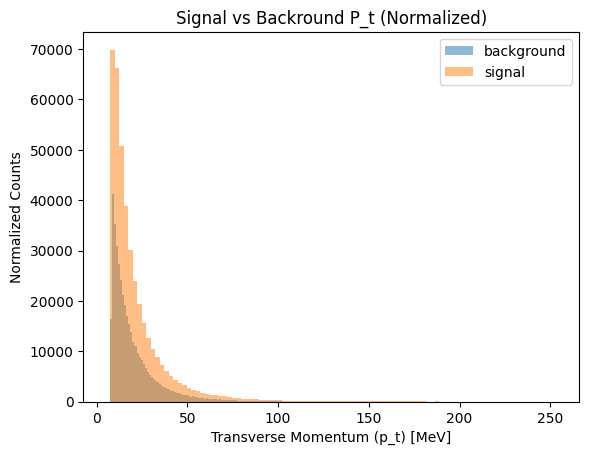

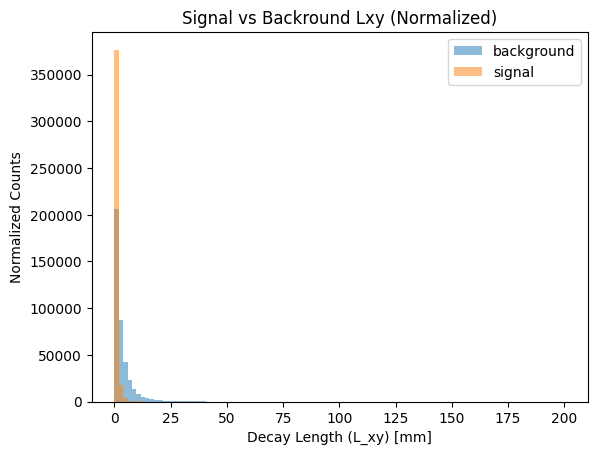

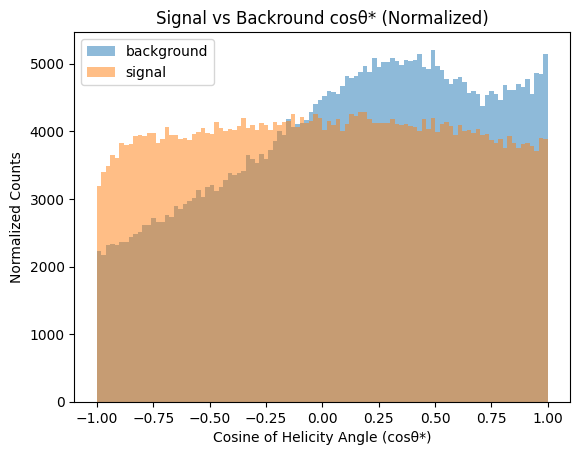

In [36]:
plt.figure()
plt.title("Pt")
hists = plt.hist(X_train1["DMesons_pt"], bins = 100, label = "background", alpha=0.5)
hists = plt.hist(X_train2["DMesons_pt"], bins = 100, label = "signal", alpha=0.5)
plt.title("Signal vs Backround P_t (Normalized)")
plt.xlabel("Transverse Momentum (p_t) [MeV]")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

plt.figure()
plt.title("Lxy")
hists1 = plt.hist(X_train1["DMesons_fitOutput__Lxy"], bins = 100, label = "background", alpha=0.5)
hists1 = plt.hist(X_train2["DMesons_fitOutput__Lxy"], bins = 100, label = "signal", alpha=0.5)
plt.title("Signal vs Backround Lxy (Normalized)")
plt.xlabel("Decay Length (L_xy) [mm]")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

plt.figure()
plt.title("costhetastar")
hists2 = plt.hist(X_train1["DMesons_costhetastar"], bins = 100, label = "background", alpha=0.5)
hists2 = plt.hist(X_train2["DMesons_costhetastar"], bins = 100, label = "signal", alpha=0.5)
plt.title("Signal vs Backround cosθ* (Normalized)")
plt.xlabel("Cosine of Helicity Angle (cosθ*)")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

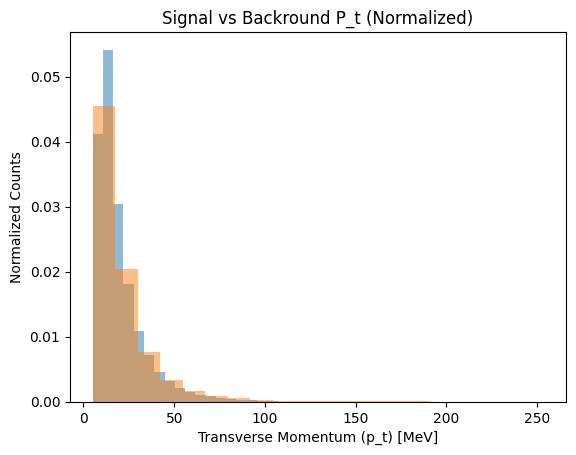

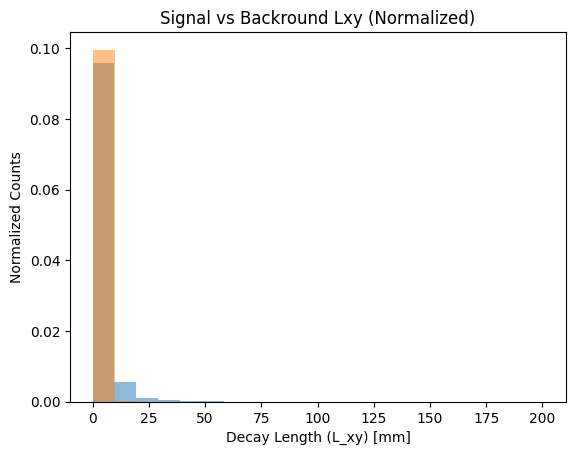

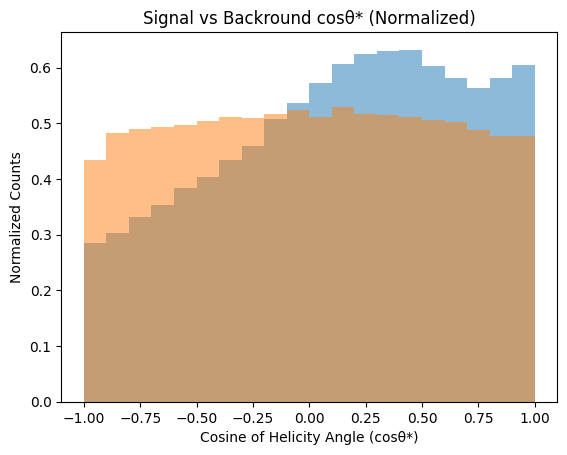

In [37]:
counts, bins, _ = plt.hist(X_train1["DMesons_pt"], bins=20)
counts2, bins2, _ = plt.hist(X_train2["DMesons_pt"], bins=20)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround P_t (Normalized)")
plt.xlabel("Transverse Momentum (p_t) [MeV]")
plt.ylabel("Normalized Counts")
plt.show()

counts, bins, _ = plt.hist(X_train1["DMesons_fitOutput__Lxy"], bins=20)
counts2, bins2, _ = plt.hist(X_train2["DMesons_fitOutput__Lxy"], bins=20)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround Lxy (Normalized)")
plt.xlabel("Decay Length (L_xy) [mm]")
plt.ylabel("Normalized Counts")
plt.show()

counts, bins, _ = plt.hist(X_train1["DMesons_costhetastar"], bins=20)
counts2, bins2, _ = plt.hist(X_train2["DMesons_costhetastar"], bins=20)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround cosθ* (Normalized)")
plt.xlabel("Cosine of Helicity Angle (cosθ*)")
plt.ylabel("Normalized Counts")
plt.show()

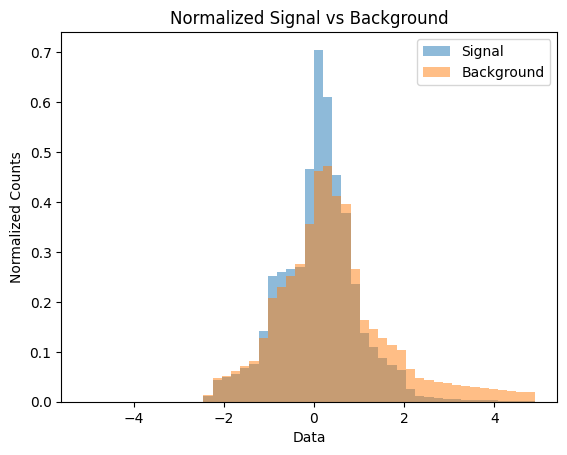

In [38]:
#counts, bins, _ = plt.hist(X_train1, bins=20)
bins = np.linspace(-5, 5, 50)
signal_counts, _ = np.histogram(X_train2, bins=bins, density=True)
background_counts, _ = np.histogram(X_train1, bins=bins, density=True)

# Plot the signal and background histograms on the same plot
plt.bar(bins[:-1], signal_counts, width=np.diff(bins), alpha=0.5, label='Signal')
plt.bar(bins[:-1], background_counts, width=np.diff(bins), alpha=0.5, label='Background')

# Add axis labels and a legend
plt.xlabel('Data')
plt.ylabel('Normalized Counts')
plt.title("Normalized Signal vs Background")
plt.legend()

# Show the plot
plt.show()

In [39]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 64,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 32,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 10,
        "batch_size": 32
    }
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gup-singh (atlasdnn). Use `wandb login --relogin` to force relogin


In [40]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

def custom_accuracy(y_true, y_pred):
    
    y_pred_binary = tf.cast(tf.round(y_pred), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    correct_predictions = tf.equal(y_true, y_pred_binary)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  320       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  2080      
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  33        
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


2023-04-17 07:44:13.499279: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [41]:
#Compile
import time

start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[custom_accuracy])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
#Train
history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
24990/25000 [============================>.] - ETA: 0s - loss: 0.4965 - custom_accuracy: 0.7674

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_074405-dzz3x88x/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_074405-dzz3x88x/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_074405-dzz3x88x/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 53s 2ms/step - loss: 0.4965 - custom_accuracy: 0.7674 - val_loss: 0.4680 - val_custom_accuracy: 0.7762
Epoch 2/10
25000/25000 [==============================] - 46s 2ms/step - loss: 0.4797 - custom_accuracy: 0.7723 - val_loss: 0.4684 - val_custom_accuracy: 0.7767
Epoch 3/10
24990/25000 [============================>.] - ETA: 0s - loss: 0.4782 - custom_accuracy: 0.7727

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_074405-dzz3x88x/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_074405-dzz3x88x/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_074405-dzz3x88x/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 47s 2ms/step - loss: 0.4782 - custom_accuracy: 0.7727 - val_loss: 0.4665 - val_custom_accuracy: 0.7776
Epoch 4/10
25000/25000 [==============================] - 46s 2ms/step - loss: 0.4790 - custom_accuracy: 0.7725 - val_loss: 0.4674 - val_custom_accuracy: 0.7772
Epoch 5/10
25000/25000 [==============================] - 46s 2ms/step - loss: 0.4781 - custom_accuracy: 0.7728 - val_loss: 0.4673 - val_custom_accuracy: 0.7760
Epoch 6/10
25000/25000 [==============================] - 46s 2ms/step - loss: 0.4783 - custom_accuracy: 0.7730 - val_loss: 0.4666 - val_custom_accuracy: 0.7767
Epoch 6: early stopping
6250/6250 [==============================] - 8s 1ms/step - loss: 0.4666 - custom_accuracy: 0.7767
Loss: [0.4665882885456085, 0.7767400145530701]
Training runtime: 292.3809893131256 seconds


2023-04-17 07:45:04.420270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-17 07:45:04.434071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-17 07:45:04.642580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-17 07:45:04

In [43]:
wandb.finish()

------------------------------------------ Finished training, now analyze ------------------------------------------

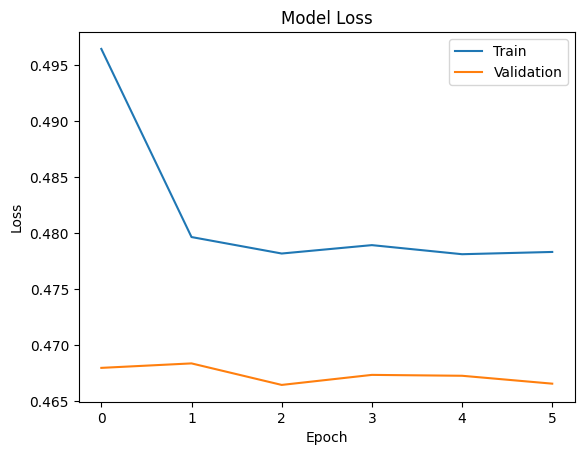

In [44]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [45]:
predictions = model.predict(X_test)
predictions[:10]

6250/6250 [==============================] - 7s 1ms/step


array([[0.71808386],
       [0.70039725],
       [0.79178286],
       [0.01058451],
       [0.06616455],
       [0.7938251 ],
       [0.73005605],
       [0.78505135],
       [0.67074215],
       [0.7503327 ]], dtype=float32)

In [46]:
predictions1 = model.predict(X_test1)
predictions1[:10]

3125/3125 [==============================] - 3s 1ms/step


array([[7.1192038e-01],
       [5.6942806e-02],
       [2.6781796e-02],
       [2.8700244e-09],
       [2.8438205e-01],
       [2.5402742e-02],
       [7.6811218e-01],
       [7.4634053e-02],
       [2.0304192e-02],
       [6.7178285e-01]], dtype=float32)

In [47]:
predictions2 = model.predict(X_test2)
predictions2[:10]

3125/3125 [==============================] - 3s 1ms/step


array([[0.71710175],
       [0.70433414],
       [0.75427043],
       [0.81452835],
       [0.74733216],
       [0.7859319 ],
       [0.5115893 ],
       [0.7551093 ],
       [0.77770126],
       [0.7311392 ]], dtype=float32)

In [51]:
predictions_list = []
D_count = 0
Lambda_count = 0
unclear = 0
for pred in predictions:
    if float(pred) > 0.5:
        predictions_list.append(int(1))
        Lambda_count+=1
    elif float(pred) < 0.5:
        predictions_list.append(int(0))
        D_count+=1
    else:
        unclear+=1
        
print("$D^+$ Count: {}".format(D_count))
print("$\Lambda_C^+ Count: {}".format(Lambda_count))
print("Unknown Particle Count: {}".format(unclear))
np.shape(predictions)

$D^+$ Count: 79443
$\Lambda_C^+ Count: 120557
Unknown Particle Count: 0


(200000, 1)

In [52]:
accuracy = np.mean(predictions_list == y_test)
print("Accuracy: {:.2%}".format(accuracy))

y_test

Accuracy: 77.67%


987231    1
79954     1
567130    0
500891    0
55399     0
         ..
90245     1
639296    0
311939    0
324459    1
390499    0
Name: DMesons_pdgId, Length: 200000, dtype: int64

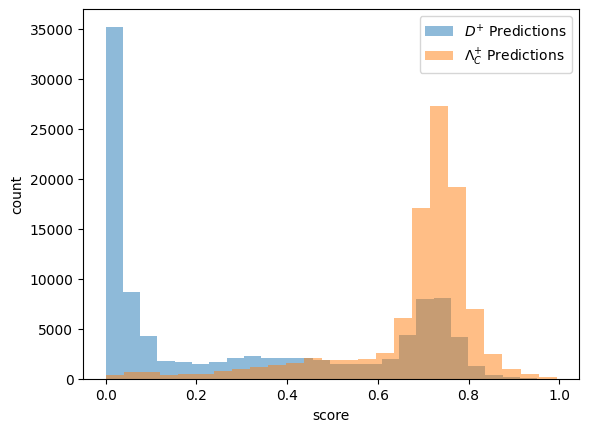

In [53]:
hist = plt.hist(predictions1, bins = 25, label = "$D^{+}$ Predictions", alpha=0.5)
hist2 = plt.hist(predictions2, bins = 25, label = "$\Lambda_C^{+}$ Predictions", alpha=0.5)
plt.xlabel("score")
plt.ylabel("count")
plt.legend()
plt.show()

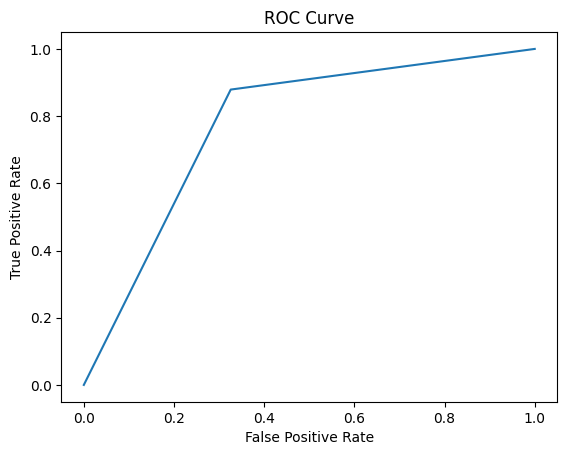

In [54]:
from sklearn.metrics import roc_curve

# Get true labels and predicted probabilities
y_true = y_test
y_pred = predictions_list

# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
